# Example 7 from: [Markov conditions and factorization in logical credal networks](https://doi.org/10.1016/j.ijar.2024.109237)

In [57]:
# Imports
import pandas as pd
from dowhy import CausalModel
import sys
sys.path.append('../scripts/')
from parser_uai import UAIParser

## First Variation

![First_Variation](./example_7_figures/image.png)

### Modeling and Data

In [58]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_1.uai", ["X1", "X2", "U1", "U2", "U3"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data


,X1,X2,U1,U2,U3
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
995,1,1,1,1,0
996,1,1,1,1,0
997,1,1,1,1,0
998,1,1,1,1,0


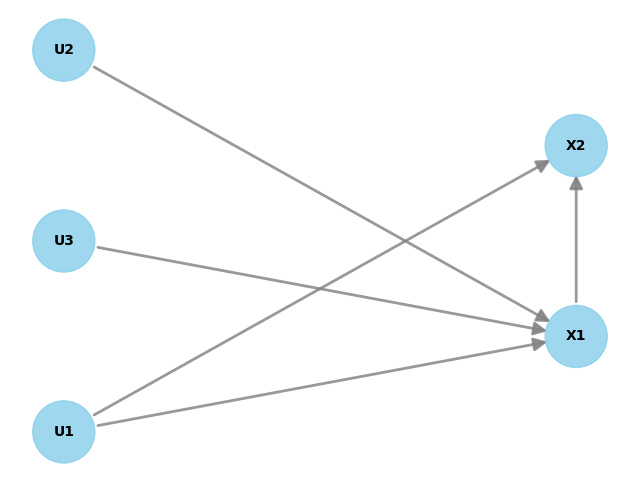

In [59]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()

### Identifying

In [60]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations

- `PropensityScoreStratification` does not work, because there is not enough data to generate at least two strata. 
- The assumptions for the `iv` estimand are not suitable in this case.
- Both methods yielded results very close to the expected value.

In [61]:
# Expected value

mean_X2_X1_1 = data[data['X1'] == 1].groupby('U1')['X2'].mean()
mean_X2_X1_0 = data[data['X1'] == 0].groupby('U1')['X2'].mean()

ate = (mean_X2_X1_1.mean() - mean_X2_X1_0.mean())

print(f"Average Treatment Effect (ATE): {ate}")

Average Treatment Effect (ATE): 0.5


In [62]:
# Propensity score matching

estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print("ATE: ", estimate_matching.value)

ATE:  0.5


In [63]:
# Propensity score weighting

estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print("ATE: ", estimate_weighting.value)

ATE:  0.5152805073833049


### Refutation

- The placebo treatment suggests that randomizing the treatment creates a noticeable (and statistically significant) shift in the estimated effect for weighting.
- However, the weighting approach does not introduce significant bias based on the dummy outcome test.

In [64]:
# Placebo treatment refuter

refuter_matching_placebo = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="placebo_treatment_refuter"
)

refuter_weighting_placebo = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="placebo_treatment_refuter"
)

In [65]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_placebo, refuter_weighting_placebo))

Matching:
Refute: Use a Placebo Treatment
Estimated effect:0.5
New effect:0.0
p value:1.0

Weighting:
Refute: Use a Placebo Treatment
Estimated effect:0.5152805073833049
New effect:-0.3867474340814504
p value:0.0



In [66]:
# Dummy outcome refuter

refuter_matching_dummy = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

refuter_weighting_dummy = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="dummy_outcome_refuter"
)

In [67]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_dummy[0], refuter_weighting_dummy[0]))

Matching:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.11138685332780651
p value:0.94

Weighting:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.004934582536843951
p value:0.94



In [68]:
refuter_matching_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_matching, 
    method_name="random_common_cause"
)

refuter_weighting_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_weighting, 
    method_name="random_common_cause"
)

In [69]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_rcc, refuter_weighting_rcc))

Matching:
Refute: Add a random common cause
Estimated effect:0.5
New effect:0.5
p value:1.0

Weighting:
Refute: Add a random common cause
Estimated effect:0.5152805073833049
New effect:0.5152805073833048
p value:1.0



### What if?

**Inputing data only for X1 and X2**

- Warning during the modeling: "*UserWarning: 3 variables are assumed unobserved because they are not in the dataset.*"
- DoWhy only identifies `iv` estimand.
- When using an `iv` estimator like `iv.instrumental_variable`, it raises an error for missing data

In [70]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_1.uai", ["X1", "X2", "U1", "U2", "U3"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data = data.drop(columns=['U1', 'U2', 'U3'])
# data

In [71]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

# model.view_model()

C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 3 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [72]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [73]:
try:
    estimate = model.estimate_effect(
        identified_estimand, 
        method_name="iv.instrumental_variable"
    )
    
    print(estimate)

except Exception as e:
    print(e)

"None of [Index(['U3', 'U2'], dtype='object')] are in the [columns]"


**Missing data for U1 (confounder)**

- Warning during the modeling: "*UserWarning: 1 variables are assumed unobserved because they are not in the dataset.*"
- DoWhy only identifies `iv` estimand.
- When using an `iv` estimator like `iv.instrumental_variable`, it yields an unexpected result.

In [110]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_1.uai", ["X1", "X2", "U1", "U2", "U3"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data = data.drop(columns=['U1'])
# data

In [111]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

# model.view_model()

C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [112]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [113]:
try:
    estimate = model.estimate_effect(
        identified_estimand, 
        method_name="iv.instrumental_variable",
        test_significance=True
    )
    print(estimate)

except Exception as e:
    print(e)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡  d       ⎤
E⎢──────(X₂)⎥
 ⎣dU3,U2    ⎦
─────────────
 ⎡  d       ⎤
E⎢──────(X₁)⎥
 ⎣dU3,U2    ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['X1'] is affected in the same way by common causes of ['X1'] and ['X2']
Estimand assumption 4, outcome_

## Second Variation

![Second_Variation](./example_7_figures/image-1.png)

### Modeling and Data

In [78]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_2.uai", ["X1", "X2", "U1", "U2"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data

,X1,X2,U1,U2
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
95,1,1,1,1
96,1,1,1,1
97,1,1,1,1
98,1,1,1,1


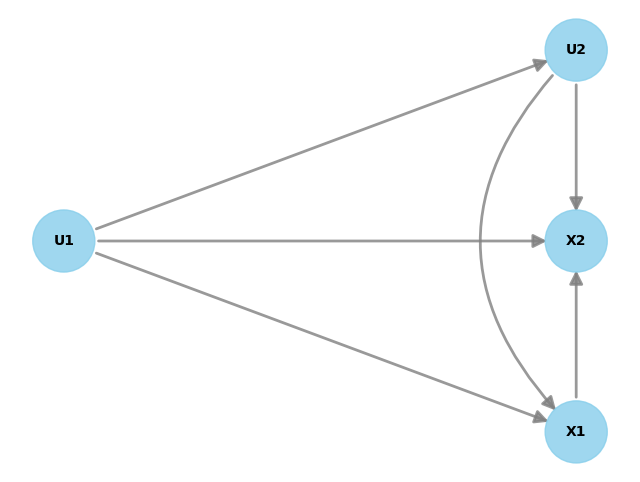

In [79]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()

### Identifying

In [80]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U1,U2])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U2,U) = P(X2|X1,U1,U2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations

- `PropensityScoreStratification` does not work, because there is not enough data to generate at least two strata.
- The `PropensityScoreMatching` method yields unexpected results.

In [81]:
mean_X2_treated = data[data['X1'] == 1].groupby(["U1", "U2"])['X2'].mean()
mean_X2_control = data[data['X1'] == 0].groupby(["U1", "U2"])['X2'].mean()


# Step 3: Calculate the ATE
ATE = mean_X2_treated.mean() - mean_X2_control.mean()

print(f"ATE: {ATE}")

ATE: 0.6666666666666666


In [82]:
# Propensity score matching

estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print("ATE: ", estimate_matching.value)

ATE:  0.5


In [83]:
# Propensity score weighting

estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print("ATE: ", estimate_weighting.value)

ATE:  0.658359063044163


### Refutation

- The placebo treatment suggests that randomizing the treatment creates a noticeable (and statistically significant) shift in the estimated effect for weighting.
- The weighting approach does not introduce significant bias based on the dummy outcome test.
- None of the refutation methods demonstrated that the matching method produced incorrect results. We understand that the refutation step aims to refute the final value obtained **using** the method, rather than refuting the method itself.

In [84]:
# Placebo treatment refuter

refuter_matching_placebo = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="placebo_treatment_refuter"
)

refuter_weighting_placebo = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="placebo_treatment_refuter"
)

In [85]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_placebo, refuter_weighting_placebo))

Matching:
Refute: Use a Placebo Treatment
Estimated effect:0.5
New effect:0.0
p value:1.0

Weighting:
Refute: Use a Placebo Treatment
Estimated effect:0.658359063044163
New effect:-0.44272992399834515
p value:0.0



In [86]:
# Dummy outcome refuter

refuter_matching_dummy = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

refuter_weighting_dummy = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="dummy_outcome_refuter"
)

In [87]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_dummy[0], refuter_weighting_dummy[0]))

Matching:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.03528534818730934
p value:0.88

Weighting:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.01784178237963286
p value:0.98



In [88]:
refuter_matching_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_matching, 
    method_name="random_common_cause"
)

refuter_weighting_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_weighting, 
    method_name="random_common_cause"
)

In [89]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_rcc, refuter_weighting_rcc))

Matching:
Refute: Add a random common cause
Estimated effect:0.5
New effect:0.5
p value:1.0

Weighting:
Refute: Add a random common cause
Estimated effect:0.658359063044163
New effect:0.6583590630441628
p value:1.0



### What if?

**Inputing data only for X1 and X2**

- Warning during modeling: "*UserWarning: 2 variables are assumed unobserved because they are not in the dataset.*"
- Identification step: No estimands were found.


In [90]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_2.uai", ["X1", "X2", "U1", "U2"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data = data.drop(columns=['U1', 'U2'])
# data

In [91]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

# model.view_model()

C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [92]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Third Variation

![Third_Variantion](example_7_figures/image-3.png)

### Modeling and Data

In [93]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_3.uai", ["X1", "X2", "U1"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data

,X1,X2,U1
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
95,1,1,3
96,1,1,3
97,1,1,3
98,1,1,3


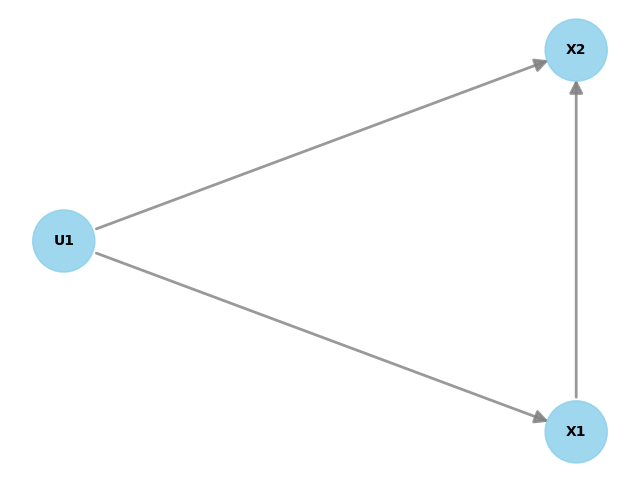

In [94]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()

### Identifying

In [95]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations

- `PropensityScoreStratification` does not work, because there is not enough data to generate at least two strata.
- The `PropensityScoreMatching` method yields unexpected results.

In [96]:
mean_X2_treated = data[data['X1'] == 1].groupby("U1")['X2'].mean()
mean_X2_control = data[data['X1'] == 0].groupby("U1")['X2'].mean()


# Step 3: Calculate the ATE
ATE = mean_X2_treated.mean() - mean_X2_control.mean()

print(f"ATE: {ATE}")

ATE: 0.33333333333333337


In [97]:
# Propensity score matching

estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print("ATE: ", estimate_matching.value)

ATE:  0.25


In [98]:
# Propensity score weighting

estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print("ATE: ", estimate_weighting.value)

ATE:  0.3224856172049566


### Refutation

- The placebo treatment suggests that randomizing the treatment creates a noticeable (and statistically significant) shift in the estimated effect for weighting.
- The weighting approach does not introduce significant bias based on the dummy outcome test.
- None of the refutation methods demonstrated that the matching method produced incorrect results. We understand that the refutation step aims to refute the final value obtained **using** the method, rather than refuting the method itself.

In [99]:
# Placebo treatment refuter

refuter_matching_placebo = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="placebo_treatment_refuter"
)

refuter_weighting_placebo = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="placebo_treatment_refuter"
)

In [100]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_placebo, refuter_weighting_placebo))

Matching:
Refute: Use a Placebo Treatment
Estimated effect:0.25
New effect:0.0005999999999999991
p value:0.96

Weighting:
Refute: Use a Placebo Treatment
Estimated effect:0.3224856172049566
New effect:-0.3135475399434673
p value:0.02



In [101]:
# Dummy outcome refuter

refuter_matching_dummy = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

refuter_weighting_dummy = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="dummy_outcome_refuter"
)

In [102]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_dummy[0], refuter_weighting_dummy[0]))

Matching:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.07579812743708073
p value:0.9

Weighting:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.0016549953491445668
p value:1.0



In [103]:
refuter_matching_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_matching, 
    method_name="random_common_cause"
)

refuter_weighting_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_weighting, 
    method_name="random_common_cause"
)

In [104]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_rcc, refuter_weighting_rcc))

Matching:
Refute: Add a random common cause
Estimated effect:0.25
New effect:0.25
p value:1.0

Weighting:
Refute: Add a random common cause
Estimated effect:0.3224856172049566
New effect:0.3224856172049567
p value:1.0



### What if?

**Inputing data only for X1 and X2**

- Warning during modeling: "*UserWarning: 1 variables are assumed unobserved because they are not in the dataset.*"
- Identification step: No estimands were found.


In [105]:
# Parsing the UAI file
model_uai = UAIParser("../data/example_7/variation_3.uai", ["X1", "X2", "U1"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data = data.drop(columns=['U1'])
# data

In [106]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

# model.view_model()

C:\Users\lucas\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [107]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Some Conclusions

- In all variations, the `PropensityScoreStratification` method did not work.
- Overall, we understand that the `PropensityScoreMatching` method is somewhat biased and can exclude a significant amount of data, leading to unexpected results.
- Refutation tests aim to refute the final value of the estimate obtained **using** the method, rather than the method itself.
- What if scenarios:
  - None of the variations worked with latent variables. Even though the first variation seemed to have identified something, the assumptions in the identification were incorrect.
